In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_df = pd.read_csv('bank-additional-full.csv',sep=';')

In [3]:
raw_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
raw_df.shape

(41188, 21)

# EDA

### Перетворення цільової колнки у відповідні значення

In [20]:
raw_df.y = raw_df.y.map({'yes':1,'no':0})

In [21]:
raw_df.y.value_counts()

,count
y,
0,36548
1,4640


### Опис числових змінних

In [26]:
numerical_df = raw_df.select_dtypes(include="number")
numerical_col = numerical_df.columns

<Axes: >

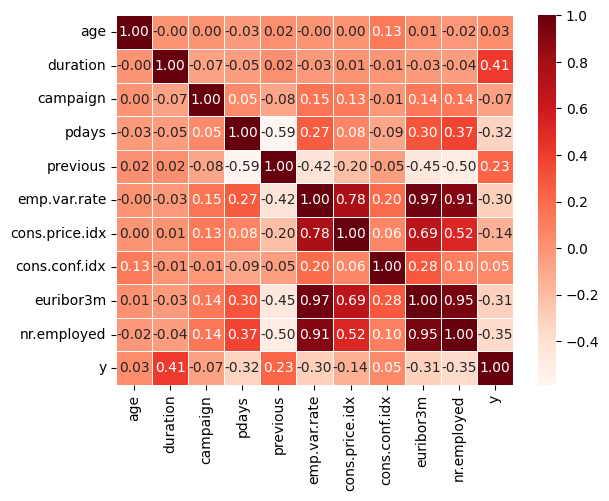

In [99]:
corr = raw_df.select_dtypes(include='number').corr()
sns.heatmap(corr, cmap='Reds', annot=True,fmt=".2f", linewidths=0.5)

In [102]:
corr.y.sort_values()

,y
nr.employed,-0.354678
pdays,-0.324914
euribor3m,-0.307771
emp.var.rate,-0.298334
cons.price.idx,-0.136211
campaign,-0.066357
age,0.030399
cons.conf.idx,0.054878
previous,0.230181
duration,0.405274


In [27]:
numerical_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000




*   Змінна `age`,`campaign`,`previous` має викиди,
*   Змінна `pdays` має дуже цікавий розподіл, оскільки число 999 є сталим при ситуації "не контактували"
*   Інші +- нормально розподілені



#### age,campaign,previous

<Axes: xlabel='age', ylabel='Count'>

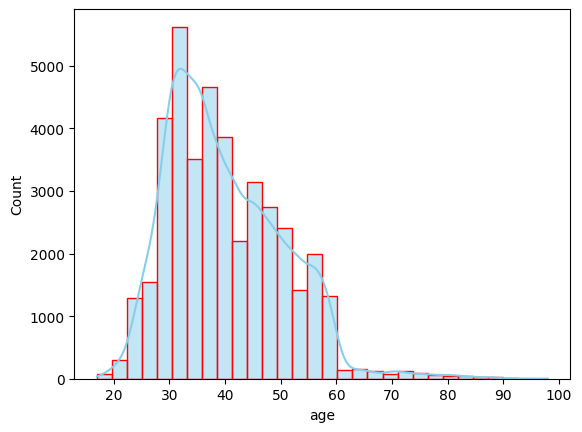

In [47]:
sns.histplot(numerical_df.age, bins=30, kde=True, color='skyblue', edgecolor='red')

по суті основна вікова категорія це від 20 до 60 років,  далі це викиди

<Axes: xlabel='campaign', ylabel='Count'>

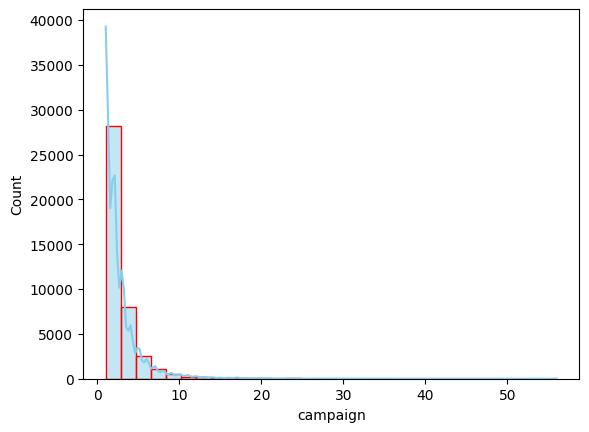

In [48]:
sns.histplot(numerical_df.campaign, bins=30, kde=True, color='skyblue', edgecolor='red')

тут також виглядає, що більше ніж 10 дзвінків - це викид

<Axes: xlabel='previous', ylabel='Count'>

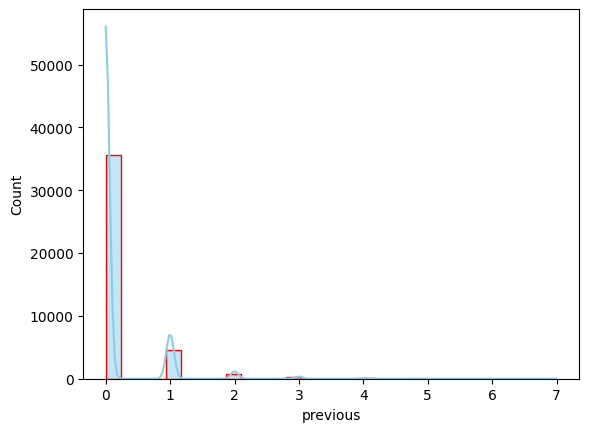

In [49]:
sns.histplot(numerical_df.previous, bins=30, kde=True, color='skyblue', edgecolor='red')

### Опис категоріальних змінних

In [51]:
categorical_df = raw_df.select_dtypes(include="object")
categorical_col = categorical_df.columns

In [52]:
categorical_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [53]:
categorical_df.job.value_counts()

,count
job,
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060


<Axes: xlabel='count', ylabel='job'>

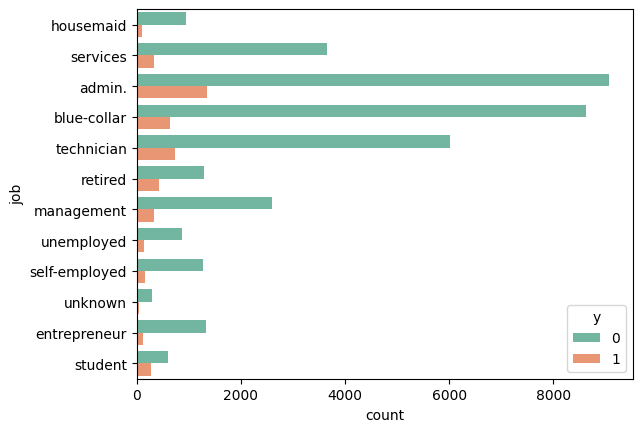

In [103]:
sns.countplot(y = "job", data = raw_df, hue ="y", palette = "Set2")

<Axes: xlabel='marital', ylabel='count'>

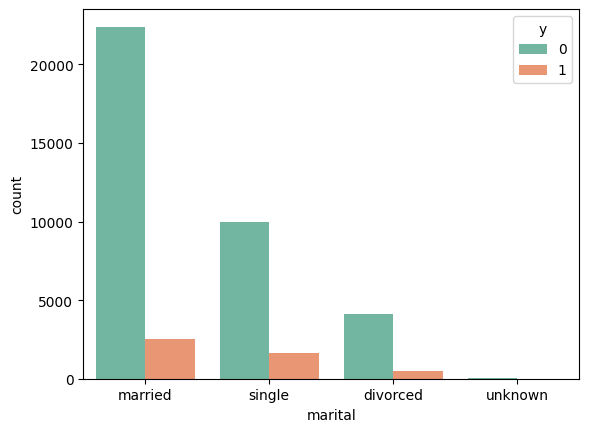

In [59]:
sns.countplot(x = "marital",hue ="y", data = raw_df,  palette = "Set2")

- видно, що переважають одружені клієнти(ті що оформили депозит, і ті що ні)
- категорія unknown можна забрати, оскільки вона не сильно впливає на розподіл

<Axes: xlabel='count', ylabel='education'>

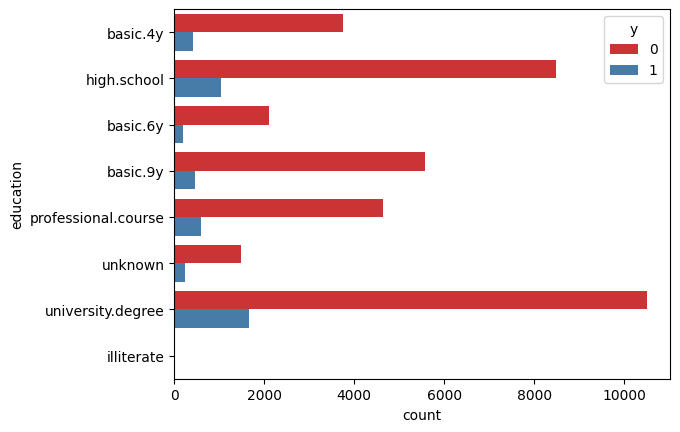

In [62]:
sns.countplot(y = "education",hue ="y", data = raw_df,  palette = "Set1")

In [70]:
categorical_df.education.value_counts()

,count
education,
university.degree,12168
high.school,9515
basic.9y,6045
professional.course,5243
basic.4y,4176
basic.6y,2292
unknown,1731
illiterate,18




*   найбільше `university.degree`
*   знову ж таки невідомої категорії не так багато, можна замінити на моду



In [72]:
categorical_df.default.value_counts()

,count
default,
no,32588
unknown,8597
yes,3




*   тут теж маємо категорію unknown, але її прям багато відносно інших відповідей, тому краще лишити як окремий вид






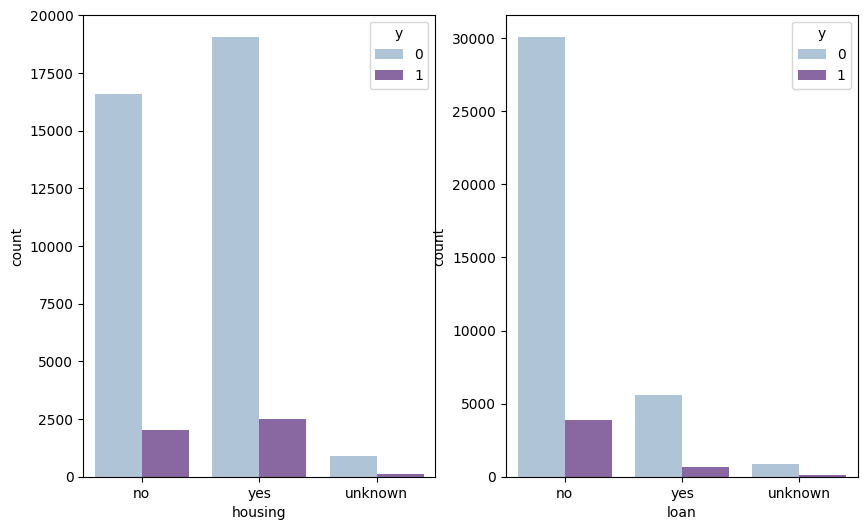

In [84]:
fig , ax = plt.subplots(1,2,figsize = (10,6))
sns.countplot(x = 'housing' ,hue = 'y',data=raw_df, ax = ax[0], palette = 'BuPu')
sns.countplot(x ='loan',hue = 'y',data=raw_df,ax = ax[1], palette = 'BuPu')
plt.show()

обєднала дві ці категорії, в них однаково розподілена категорія unknown, тому б її теж замінила - і перетворила їх на числові колонки

In [85]:
categorical_df.contact.value_counts()

,count
contact,
cellular,26144
telephone,15044




*   Оскільки тут тільки два значення певно теж краще закодувати в 0-1 , створити ще одну колонку і саме її враховувати в навчаннях



<Axes: xlabel='count', ylabel='month'>

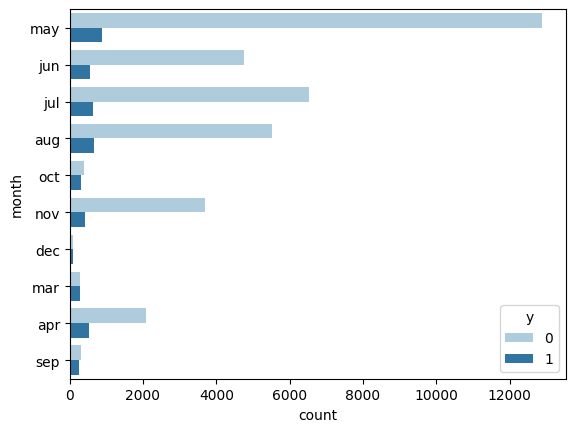

In [89]:
sns.countplot(y = "month",hue ="y", data = raw_df,  palette = "Paired")

In [87]:
categorical_df.day_of_week.value_counts()

,count
day_of_week,
thu,8623
mon,8514
wed,8134
tue,8090
fri,7827


<Axes: xlabel='poutcome', ylabel='count'>

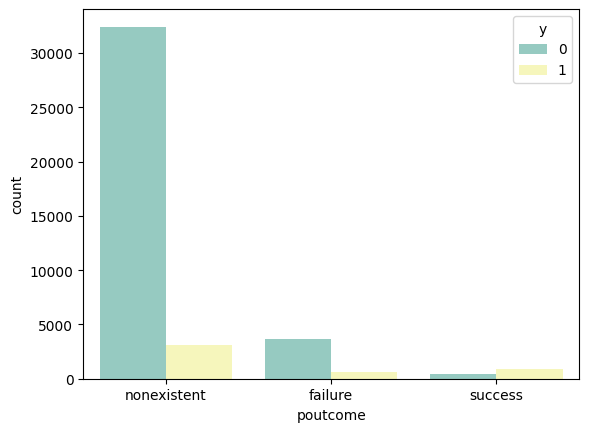

In [93]:
sns.countplot(x = "poutcome",hue ="y", data = raw_df,  palette = "Set3")

ці три колонки ніяк не потрібно змінювати, можна помітити, що дні тижня коли проходила компанія розподілена рівномірно, а от найбільш активний місяць був травень
і з останньої колонки зрозуміло, що дуже багато нових клієнтів

### Гіпотези


*   як було вказано в умові `duration` впливає на цільову змінну, що логічно бо якщо клієнт зацікавлений в депозиті буде більше питати
*   також на цільову змінну "негативно" вливає `nr.employed`, чим краща екноміка, тим менше людей хоче відкривтаи депозити-кредити
*   також якщо з клієнтом був попередній успішний досвід попередньої кампанії, він більш ймовірно і цього разу "включиться"




# Вітаю вас на Mid-term проєкті!

Цей проєкт призначений для того, щоб ви могли оновити та закріпити знання, які ви отримали за перші місяці навчання на курсі "Machine Learning для людей".

### Основна задача

В цьому завданні Ви - Data Scientist в барнку. Ваша задача - побудувати модель для передбачення, чи оформить клієнт в банку строковий депозит (term deposit). З подібними задачами ми стикаємось в різних компаніях і доменах, коли хочемо зрозуміти, чи клієнт купить якийсь продукт, чи буде користуватись нашим сервісом/сайтом у наступному місяці, чи придбає підписку.

Вам треба не просто побудувати модель, а і пояснити замовнику (ваш замовник тут - це ми з кураторами) як працює ця модель і чому вона дає саме такі рішення. Без цього розуміння ми не можемо перейти до впроваждення (деплойменту) моделі в продакшен.

### Практичне застовування

В реальних робочих умовах в подібних задачах у Вас дані будуть зберігатись в базі данних в динаміці (різні дії користувачів з датою і часом). Тут дані вже загреговані по клієнтам і часто саме з цього ви будете починати побудову моделі передбачення, адже це відносно просто і зручно: загрегувати дані по клієнтам до певного часу і передбачати в майбутнє (тільки в випадку тренування моделі ML наше "майбутнє" теж фактично в минулому - бо ми хочемо мати мітки в даних, а от вже при використанні моделі в продакшені і бойових умовах ви справді будете робити передбачення в майбутнє). Тож, розвʼязуємо задачку!

### Датасет і ML задача

Для виконання завдання ми використаємо набір даних, який оригінально походить з сайту [UCI Machine Learning Repository], але там неточний опис даних і багато різних піднаборів, тому ми братимемо з Kaggle dataset: https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv.

Ці дані стосуються прямих маркетингових кампаній (телефонних дзвінків) португальської банківської установи. Кінцева мета класифікації - передбачити, чи підпише клієнт строковий депозит (змінна y).

Ми будемо працювати з файлом `bank-additional-full.csv`, скачати набір даних треба з Kaggle. Або можна скачати цей самий набір з гугл диска [тут](https://drive.google.com/file/d/1pDr0hAOnu1JsEiJeBu_F2Jv0GPxKiujW/view?usp=drive_link)

### Опис змінних

Цей опис є і на Kaggle, але ми переклали для вашої зручності і аби він був у вас перед очима під час роботи над проєктом.

#### **Дані про клієнта банку**:
1. **age** – вік клієнта (числова змінна).  
2. **job** – вид зайнятості (категоріальна змінна: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`).  
3. **marital** – сімейний стан (категоріальна змінна: `divorced`, `married`, `single`, `unknown`; примітка: `divorced` означає розлучений або вдівець/вдова).  
4. **education** – рівень освіти (категоріальна змінна: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`).  
5. **default** – чи є у клієнта прострочений кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
6. **housing** – чи має клієнт іпотечний кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
7. **loan** – чи має клієнт споживчий кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  

#### **Дані про останній контакт у межах поточної маркетингової кампанії**:
8. **contact** – тип зв’язку при останньому контакті (категоріальна змінна: `cellular`, `telephone`).  
9. **month** – місяць останнього контакту (категоріальна змінна: `jan`, `feb`, `mar`, …, `nov`, `dec`).  
10. **day_of_week** – день тижня останнього контакту (категоріальна змінна: `mon`, `tue`, `wed`, `thu`, `fri`).  
11. **duration** – тривалість останнього контакту в секундах (числова змінна).  
   ⚠ **Важлива примітка**: ця змінна має суттєвий вплив на цільову змінну (наприклад, якщо duration = 0, то y = `no`). Однак значення duration невідоме до здійснення дзвінка. Крім того, після завершення дзвінка значення y вже відоме. Тому цю змінну варто використовувати лише для порівняння моделей, але не включати у фінальну передбачувальну модель.  

#### **Інші атрибути**:
12. **campaign** – кількість контактів у межах поточної кампанії для цього клієнта (числова змінна, включає останній контакт).  
13. **pdays** – кількість днів, що минули з моменту останнього контакту клієнта у попередній кампанії (числова змінна; значення 999 означає, що клієнт раніше не контактувався).  
14. **previous** – кількість контактів, здійснених до цієї кампанії для цього клієнта (числова змінна).  
15. **poutcome** – результат попередньої маркетингової кампанії (категоріальна змінна: `failure`, `nonexistent`, `success`).  

#### **Атрибути соціально-економічного контексту**:
16. **emp.var.rate** – темп зміни зайнятості (щоквартальний показник, числова змінна).  
17. **cons.price.idx** – індекс споживчих цін (щомісячний показник, числова змінна).  
18. **cons.conf.idx** – індекс довіри споживачів (щомісячний показник, числова змінна).  
19. **euribor3m** – ставка Euribor на 3 місяці (щоденний показник, числова змінна).  
20. **nr.employed** – кількість працевлаштованих осіб (щоквартальний показник, числова змінна).  

#### **Цільова змінна**:
21. **y** – чи підписав клієнт строковий депозит? (бінарна змінна: `yes`, `no`).

### Ваше завдання на цей проєкт

Необхідно побудувати рішення цієї задачі бінарної класифікації. Для цього

1. Провести Exploratory Data Analysis і висунути гіпотези щодо впливу окремих ознак на цільову ознаку `y`.

2. Описати, які методи ви вважаєте доречним використовувати і обрати метрику оцінки якості моделей (метрику треба обґрунтувати).

3. Провести препроцесинг даних для подальшої їх передачі в модель. Препроцесинг має включати
  - обробку категоріальних змінних (якщо цього потребує модель)
  - групування категорій в категоріальних змінних, якщо потрібно
  - заповнення пропущених значень, якщо такі є
  - виявлення outliers і прийняття рішень, що з ними робити
  - створення додаткових ознак, які на ваш погляд поліпшать якість моделей ML.

4. Натренувати 4 різні типи моделей машинного навчання, з яких обовʼязково
  - Logistic Regression
  - kNN
  - Decision Tree
  - Принаймні один з алгоритмів бустингу

5. Створити таблицю з порівнянням якості моделей (в Google Spreadsheets або прямо в Jupyter Notebook), де зазначити
  - назву моделі
  - гіперпараметри
  - метрика якості моделі на тренувальному наборі
  - метрика якості моделі на валідаційному наборі даних
  - коментар до моделі - хороша вона, чи ні, чи варто її використовувати чи ні, чи є у вас подальші ідеї щодо експериментів з цією моделлю?

6. Для алгоритму бустингу виконати процедуру тюнингу гіперпараметрів двома способами
  - Sklearn: Randomized Search
  - Hyperopt: Bayesian Optimization.
  Виявити оптимальні гіперпараметри і зробити висновки про якість моделі в кожному з випадків.

7. Вивести важливість ознак для моделі, які показала себе найкраще і описати, чи вважаєте ви саме такий пріоритет важливості ознак адекватним з точки зору common sense?

8. Для найкращої провести аналіз впливу ознак на передбачення з допомогою бібліотеки SHAP.

9. Провести аналіз записів, в яких модель помиляється і на основі нього зазначити, яким чином можна поліпшити наявне рішення аби уникати наявних помилок?


### Результат виконання проєкту

Результатом виконання цього завдання є окремий github репозиторій з охайно оформленим Jupyter Notebook, частина коду може бути винесена в .py файли. Репозиторій має містити опис задачі, опис що було зроблено і які моделі використано, таблицю результатів експериментів (можна скріншотом або створити таблицю в Markdown форматі - див. Приклад) і висновки, що Ви досягли і що можна було б ще зробити для поліпшення результатів.


### Приклад проєкту

Для натхнення ви можете ознайомитись з проєктом, побудованим на основі цих даних за [цим посиланням](https://github.com/surtantheta/Bank_Marketing_Dataset_Machine_Learning_Project).




![](https://blogconcept2competence.wordpress.com/wp-content/uploads/2014/03/yoda.jpg)